# Whitening

Select the optimal radiomics feature pre-processing procedure.

* See [notes](http://joelouismarino.github.io/blog_posts/blog_whitening.html).

In [22]:
import whitening

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing

%matplotlib inline

In [1]:
# TEMP:
def whiten(X, method='zca'):
    """
    Whitens the input matrix X using specified whitening method.
    Inputs:
        X:      Input data matrix with data examples along the first dimension
        method: Whitening method. Must be one of 'zca', 'zca_cor', 'pca',
                'pca_cor', or 'cholesky'.
    """
    X = X.reshape((-1, np.prod(X.shape[1:])))
    X_centered = X - np.mean(X, axis=0)
    Sigma = np.dot(X_centered.T, X_centered) / X_centered.shape[0]
    W = None
    
    if method in ['zca', 'pca', 'cholesky']:
        U, Lambda, _ = np.linalg.svd(Sigma)
        if method == 'zca':
            W = np.dot(U, np.dot(np.diag(1.0 / np.sqrt(Lambda + 1e-5)), U.T))
        elif method =='pca':
            W = np.dot(np.diag(1.0 / np.sqrt(Lambda + 1e-5)), U.T)
        elif method == 'cholesky':
            W = np.linalg.cholesky(np.dot(U, np.dot(np.diag(1.0 / (Lambda + 1e-5)), U.T))).T
    elif method in ['zca_cor', 'pca_cor']:
        V_sqrt = np.diag(np.std(X, axis=0))
        P = np.dot(np.dot(np.linalg.inv(V_sqrt), Sigma), np.linalg.inv(V_sqrt))
        G, Theta, _ = np.linalg.svd(P)
        if method == 'zca_cor':
            W = np.dot(np.dot(G, np.dot(np.diag(1.0 / np.sqrt(Theta + 1e-5)), G.T)), V_sqrt)
        elif method == 'pca_cor':
            W = np.dot(np.dot(np.diag(1.0/np.sqrt(Theta + 1e-5)), G.T), V_sqrt)
    else:
        raise Exception('Whitening method not found.')
    
    return np.dot(X_centered, W.T)

In [4]:
X = pd.read_csv('./../../../data_source/to_analysis/complete.csv', index_col=0)
X.head()

,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxis,original_shape_MajorAxis,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MinorAxis,original_shape_Sphericity,...,Cisplatin_1,Cisplatin_2,Cisplatin_3,Cisplatin_4,Cisplatin_5,Cisplatin_6,Stage 1,Stage 2,Stage 3,Stage 4
patient,,,,,,,,,,,,,,,,,,,,,
2,0.738882,0.723925,27.060529,37.380273,41.976184,44.598206,42.720019,45.617979,27.619612,0.661532,...,0,0,0,0,0,1,0,0,0,1
4,0.796900,0.629917,19.845151,31.504408,38.587563,35.468296,29.410882,38.704005,25.105855,0.701721,...,0,0,0,0,1,0,0,0,0,1
5,0.600926,0.535140,22.515072,42.073251,46.065171,43.011626,32.015621,46.454279,25.282894,0.762365,...,0,0,0,0,0,0,0,1,0,0
8,0.784571,0.414247,30.263897,73.057649,74.148500,80.956779,65.764732,83.438600,57.318945,0.520001,...,0,0,1,0,0,0,0,0,0,1
10,0.690320,0.539743,19.449801,36.035312,33.286634,38.013156,33.015148,43.150898,24.875896,0.643822,...,0,0,0,0,0,1,0,0,0,1


In [5]:
X.shape

(198, 241)

In [41]:
Z_pca = pd.DataFrame(
    whiten(X.values, method='pca'), columns=X.columns, index=X.index
)
Z_pca_cor = pd.DataFrame(
    whiten(X.values, method='pca_cor'), columns=X.columns, index=X.index
)
Z_zca = pd.DataFrame(
    whiten(X.values, method='zca'), columns=X.columns, index=X.index
)
Z_zca_cor = pd.DataFrame(
    whiten(X.values, method='zca_cor'), columns=X.columns, index=X.index
)

/Users/severinlangberg/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


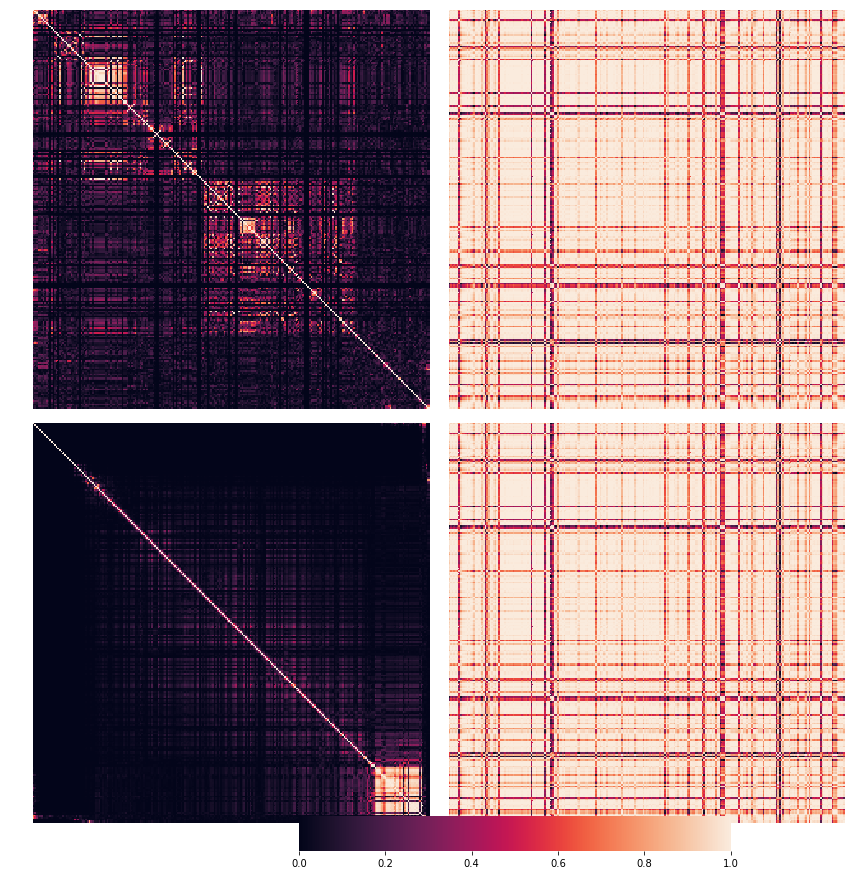

In [59]:
Z_pca_corr_mat = Z_pca.corr().abs()
Z_pca_cor_corr_mat = Z_pca_cor.corr().abs()
Z_pca_corr_mat = Z_zca.corr().abs()
Z_pca_cor_corr_mat = Z_zca_cor.corr().abs()

fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(12, 12),
    sharex=True, sharey=True
)
cbar_ax = fig.add_axes([0.35, 0.01, 0.5, 0.04])
sns.heatmap(
    Z_pca_corr_mat.values, ax=axes[0, 0], cbar=True, cbar_ax=cbar_ax,
    cbar_kws={'orientation': 'horizontal'}
)
sns.heatmap(Z_pca_cor_corr_mat.values, ax=axes[0, 1], cbar=False)
sns.heatmap(corr_matrix.values, ax=axes[1, 0], cbar=False)
sns.heatmap(Z_pca_cor_corr_mat.values, ax=axes[1, 1], cbar=False)

for axis in axes.ravel():
    axis.axis('off')

plt.tight_layout()

In [14]:
Z_df.to_csv('./../../../data_source/to_analysis/zca_corr_complete.csv')